## Importación de Librerías

In [53]:
import pandas as pd
import numpy as np
from sklearn import preprocessing
import matplotlib.pyplot as plt
from scipy.interpolate import PchipInterpolator




## Carga de Datos

In [54]:
users = pd.read_excel('../resources/1_raw/Usuarios_Teleferico.xlsx')
meteor = pd.read_excel('../resources/1_raw/Madrid_Meteorologia.xlsx', parse_dates=['Fecha'])
festive = pd.read_csv('../resources/1_raw/Tipo_Dia.csv', sep = ';')
output_file = '../resources/2_preprocessed/dataset_completo.xlsx'

## Definición de Funciones

In [55]:
# Definición de variables que modifican la construcción del dataset

neg_noise = 800 # Porcentaje de ruido negativo en la variable objetivo Ejemplos: 0, 10, 100
pos_noise = 800 # Porcentaje  de ruido positivo en la variable objetivo Ejemplos: 0, 10, 100

keep_null_values = 2 # 0 para eliminar los valores nulos, 1 para mantenerlos con valor 0 y 2 para generar un valores aleatorios

In [56]:
def interpolate_null_values(df):
    df['Fecha'] = pd.to_datetime(df['Fecha'])
    
    df.set_index('Fecha', inplace=True)
    
    if keep_null_values == 2:
        df_resampled = df.resample('D').asfreq()
        
        missing_indices = df_resampled[df_resampled['CantidadUsuarios'].isna()].index
        
        non_missing_indices = df_resampled['CantidadUsuarios'].dropna().index
        non_missing_values = df_resampled.loc[non_missing_indices, 'CantidadUsuarios']
        
        if len(non_missing_indices) > 1:
            non_missing_ordinal = non_missing_indices.map(pd.Timestamp.toordinal).values
            missing_ordinal = missing_indices.map(pd.Timestamp.toordinal).values
            
            pchip = PchipInterpolator(non_missing_ordinal, non_missing_values, extrapolate=False)
            
            interpolated_values = pchip(missing_ordinal)
            
            interpolated_values[interpolated_values < 0] = 0
            
            df_resampled.loc[missing_indices, 'CantidadUsuarios'] = interpolated_values
            
            np.random.seed(0)
            for idx in missing_indices:
                day_of_week = idx.dayofweek
                if day_of_week >= 4 and day_of_week <= 7:  # Thursday (4), Friday (5), Saturday (6), Sunday (7)
                    df_resampled.at[idx, 'CantidadUsuarios'] += np.random.uniform(0, pos_noise)
                else:
                    perturbation = np.random.uniform(-neg_noise, 0)
                    df_resampled.at[idx, 'CantidadUsuarios'] += perturbation
                    if df_resampled.at[idx, 'CantidadUsuarios'] < 0:
                        df_resampled.at[idx, 'CantidadUsuarios'] = 0
        else:
            print("Not enough data to perform interpolation.")
    
    return df_resampled.reset_index()
 

In [57]:
def control_null_people(date, date2, amount_users):
    new_amount = []
    real_values = 0
    null_values = 0
    for i in range(len(date2)):
        if date2[i] in date:
            real_values += 1
            new_amount.append(amount_users[np.nonzero(date == date2[i])])
        else:
            null_values += 1
            if keep_null_values == 1:
                new_amount.append(0)
            else:
                new_amount.append(np.nan)

    print("Real values: ", real_values)
    print("Null values: ", null_values)
    
    df = pd.DataFrame({
        'Fecha': date2.flatten(),
        'CantidadUsuarios': new_amount
    })
    
    df['CantidadUsuarios'] = df['CantidadUsuarios'].astype(float)

    #amount_users_interpolated = interpolate_null_values(df)
    
    return df['CantidadUsuarios'] 

In [58]:
def convert_to_list(array):
    new_list = []
    for i in array:
        new_list.append(i[0]) 
    return new_list

## Tratamiento de Datos

In [59]:
# Primer excel
users.dropna(subset = ['Fecha'], inplace=True)
users = users.groupby('Fecha',as_index =False).sum()
date = users.iloc[:,[0]].values
amount_users = users.iloc[:,[3]].values

In [60]:
# Segundo excel
meteor.dropna(subset = ['Fecha'], inplace=True)
meteor = meteor[(meteor.Fecha >= date[0,0]) & (meteor.Fecha <= date[date.size-1,0])]
date2 = meteor.iloc[:,[0]].values
weekday = meteor.iloc[:,[1]].values 
temperature = meteor.iloc[:,[4]].values 
rainfall = meteor.iloc[:,[5]].values

In [61]:
# Tercer excel
festive = festive[(pd.to_datetime(festive['Dia'], dayfirst=True) >= date[0,0]) & (pd.to_datetime(festive['Dia'], dayfirst=True) <= date[date.size-1,0])]
festive = festive.iloc[:,[3]].values

In [62]:
# Pasar strings a numericos
encoder = preprocessing.LabelEncoder()
encoder.fit(festive.ravel())
festive = [encoder.transform(festive.ravel())]
festive = np.transpose(festive)

In [63]:
# Se introducen valores nuevos que antes eran nulos
amount_users_modified = control_null_people(date, date2, amount_users)

Real values:  440
Null values:  176


In [64]:
# Se genera el nuevo dataset con todos los datos necesarios
writer = pd.ExcelWriter(output_file, engine='xlsxwriter')
date2 = convert_to_list(date2)
festive = convert_to_list(festive)
weekday = convert_to_list(weekday)
temperature = convert_to_list(temperature)
rainfall = convert_to_list(rainfall)

df = pd.DataFrame({'Fecha':date2,
                   'Festivo':festive,
                   'DiaSemana':weekday,
                   'Temperatura':temperature,
                   'Precipitacion':rainfall,
                   'CantidadUsuarios':amount_users_modified})

if keep_null_values == 0:
    df = df.dropna()
elif keep_null_values == 1:
    df['CantidadUsuarios'] = df['CantidadUsuarios'].fillna(0)
else:
    df = interpolate_null_values(df)

df.to_excel(writer, sheet_name='teleferico', index=False)
writer.close()

## Visualización de la Serie Temporal para la cantidad de usuarios

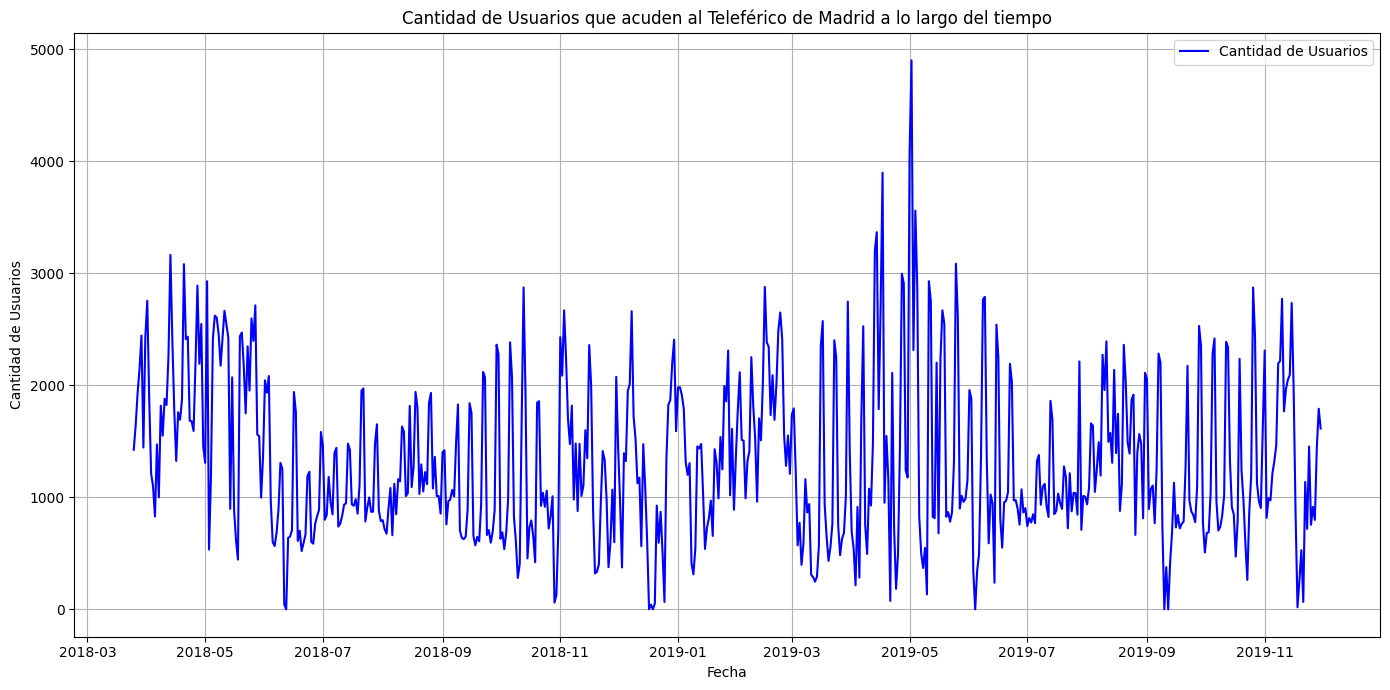

In [65]:
# Leer el dataset
dataset = pd.read_excel(output_file)
# Visualizar la serie temporal
plt.figure(figsize=(14,7))
plt.plot(dataset['Fecha'], dataset['CantidadUsuarios'], label='Cantidad de Usuarios', color='blue')
plt.title('Cantidad de Usuarios que acuden al Teleférico de Madrid a lo largo del tiempo')
plt.xlabel('Fecha')
plt.ylabel('Cantidad de Usuarios')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()